# Ejercicio Ridge, Lasso y ElasticNet
Para este ejercicio vas a trabajar con datos de ventas de una empresa que fabrica muebles en España. Esta empresa es una Pyme que demanda conocer de antemano qué ingresos va a tener cada mes, ya que necesita pedir un anticipio a su entidad financiera de cara a poder abastecerse de materia prima al comenzar el mes. Como desconoce cuánto tiene que pedir, tira al alza y acaba pagando muchos intereses. El objetivo es reducir estos gastos.

En las bases de datos de la empresa constan todos los gastos en publicidad y ventas, para cada uno de los meses desde su fundación (hace más de 15 años).

Dado que los presupuestos de marketing se cierran al principio de cada mes, la empresa necesita un modelo predictivo que le anticipe las ventas que conseguirá a final de mes en función de los gastos que realizará en marketing.

Para ello tendrás que utilizar tanto modelos de regresión normales, como regularizados.

1. Carga los datos y realiza un pequeño análisis exploratorio. Mira a ver cómo se relaciona las ventas con el resto de variables.
2. Crea varios modelos y modifica los hiperparámetros necesarios para mejorar el performance del modelo.
3. Interpreta los resultados. Traduce a una fórmula tu mejor modelo (escribir la fórmula simplemente). ¿Cuánto cambian las ventas si aumentamos la inversión en radio un punto más? ¿Y si aumentamos la inversión en TV o periódicos?

## Import libraries 

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso




## Exploratory Data Analysis 

In [11]:
# Lectura datos, relación variables, mapas de correlación...
df_adv = pd.read_csv('data/Advertising.csv',usecols=[1,2,3,4])
df_adv.head()

,TV,radio,newpaper,sales
0,230.1,37.8,6s9.2,22100.0
1,44.5,39.3,45.1,10400.0
2,17.2,45.9,69.3,9300.0
3,151.5,41.3,58.5,18500.0
4,180.8,10.8,58.4,12900.0


In [12]:
df_adv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TV        200 non-null    float64
 1   radio     200 non-null    float64
 2   newpaper  200 non-null    object 
 3   sales     200 non-null    float64
dtypes: float64(3), object(1)
memory usage: 6.4+ KB


La fila 1 de newspaper está rara, lo que hace que newspaper sea object. Me quito esa fila y transformo a float

In [13]:
df_adv.drop(labels=0,axis=0,inplace=True)

In [14]:
df_adv['newpaper'] = df_adv['newpaper'].astype('float64')
df_adv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 1 to 199
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TV        199 non-null    float64
 1   radio     199 non-null    float64
 2   newpaper  199 non-null    float64
 3   sales     199 non-null    float64
dtypes: float64(4)
memory usage: 6.3 KB


In [20]:
df_adv.describe(include='all')

,TV,radio,newpaper,sales
count,199.000000,199.000000,199.000000,199.000000
mean,146.625126,23.190955,30.359799,13981.909548
std,85.867111,14.848182,21.659246,5198.861022
min,0.700000,0.000000,0.300000,1600.000000
25%,74.050000,9.950000,12.700000,10350.000000
50%,149.700000,22.500000,25.600000,12900.000000
75%,218.450000,36.400000,44.700000,17350.000000
max,296.400000,49.600000,114.000000,27000.000000


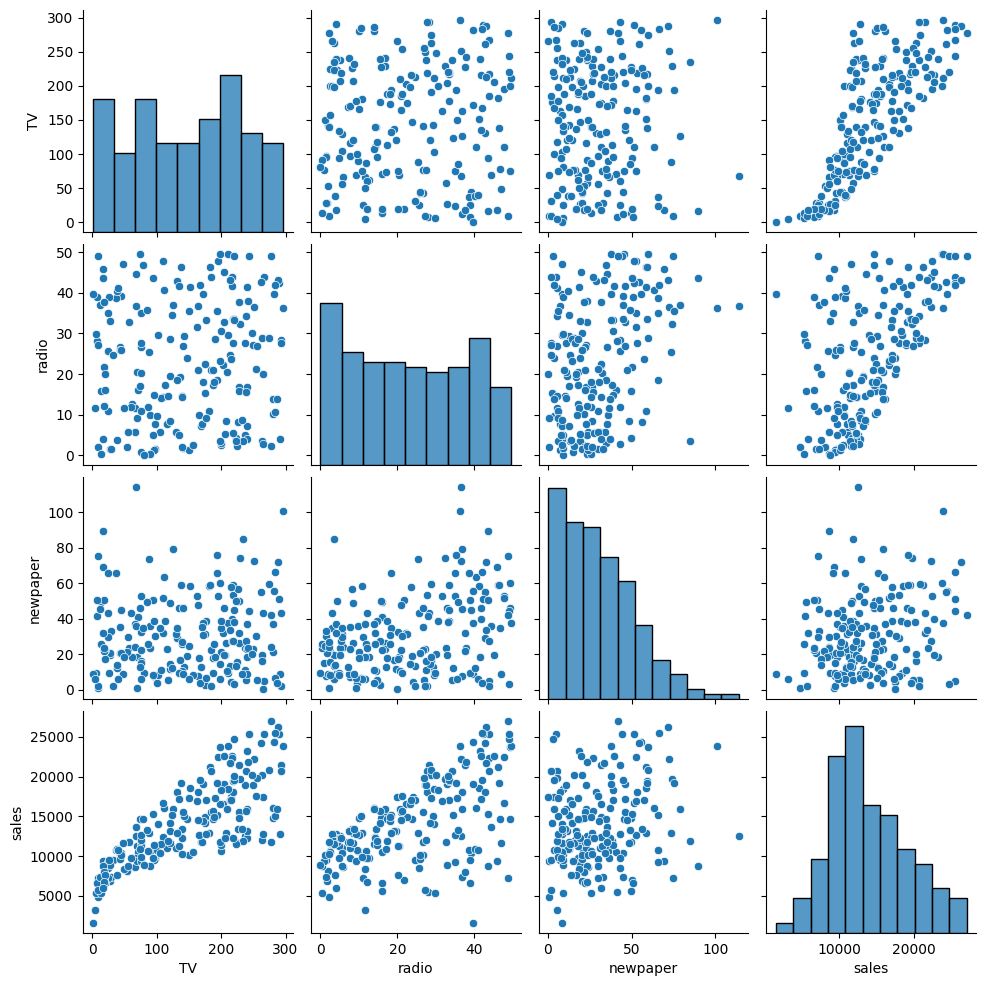

In [21]:
sns.pairplot(df_adv)

- target con distribución más o menos normal.
- Todas las variables parecen correladas con sales, tal vez newspaper algo menos. corr lineal con radio, tal vez polinómica con TV.
- radio y newspaper pueden estar correladas

<Axes: >

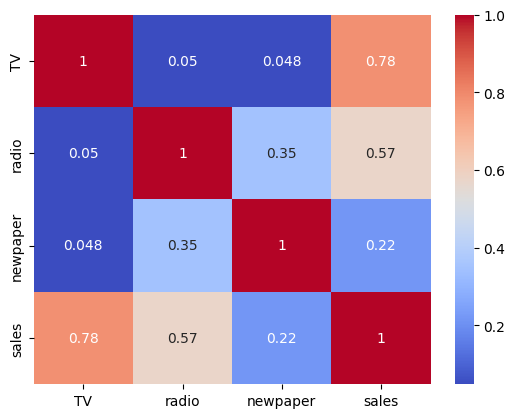

In [22]:
sns.heatmap(df_adv.corr(), annot=True, cmap='coolwarm')

TV y radio tienen buena pinta: TV está muy correlada, radio un poco menos, y no hay corr entre ellas

## Modelado

In [16]:
# Manipulación datasets, entrenamiento, evaluación, nuevas iteraciones... Prueba modelos sin y con regularización.

Probaremos a priori dos modelos:
- 1: TV + radio
- 2: sólo TV

A partir de ahí vemos mejorarlos con regularización, polinómicos...
Partiremos también con las variables explicativas ya normalizadas

In [27]:
### tratamiento previo y normalización
x1 = df_adv[['TV','radio']].copy()
y1 = df_adv['sales'].copy()
scaler = preprocessing.StandardScaler()
scaler.fit(x1)
x1 = scaler.transform(x1)
x1_train, x1_test, y1_train, y1_test = train_test_split(x1,y1, test_size=.2, random_state=42)

### Comprobamos shapes
print("Total features shape:", x1.shape)
print("Train features shape:", x1_train.shape)
print("Train target shape:", y1_train.shape)
print("Test features shape:", x1_test.shape)
print("Test target shape:", y1_test.shape)

Total features shape: (199, 2)
Train features shape: (159, 2)
Train target shape: (159,)
Test features shape: (40, 2)
Test target shape: (40,)


In [29]:
lm1 = LinearRegression()
lm1.fit(x1_train,y1_train)
pred1 = lm1.predict(x1_test)
print('MAE_1:', metrics.mean_absolute_error(y1_test, pred1))
print('RMSE_1:', metrics.root_mean_squared_error(y1_test, pred1))
print('='*20)
print('r2_1 train',lm1.score(x1_train,y1_train))
print('r2_1 test',lm1.score(x1_test,y1_test))

MAE_1: 1254.045650565491
RMSE_1: 1586.9598806847262
r2_1 train 0.8987745442963155
r2_1 test 0.8734673573124376


<Axes: xlabel='sales'>

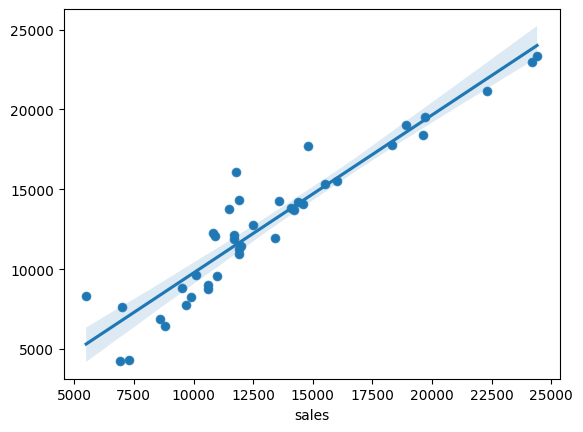

In [33]:
sns.scatterplot(x=y1_test,y=pred1)
sns.regplot(x=y1_test,y=pred1)

Cierta curvatura podría venirle bien al modelo. 

In [34]:
x2 = df_adv[['TV']].copy()
y2 = df_adv['sales'].copy()
scaler = preprocessing.StandardScaler()
scaler.fit(x2)
x2 = scaler.transform(x2)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2,y2, test_size=.2, random_state=42)

### Comprobamos shapes
print("Total features shape:", x2.shape)
print("Train features shape:", x2_train.shape)
print("Train target shape:", y2_train.shape)
print("Test features shape:", x2_test.shape)
print("Test target shape:", y2_test.shape)

Total features shape: (199, 1)
Train features shape: (159, 1)
Train target shape: (159,)
Test features shape: (40, 1)
Test target shape: (40,)


In [36]:
lm2 = LinearRegression()
lm2.fit(x2_train,y2_train)
pred2 = lm2.predict(x2_test)
print('MAE_1:', metrics.mean_absolute_error(y1_test, pred1))
print('RMSE_1:', metrics.root_mean_squared_error(y1_test, pred1))
print('MAE_2:', metrics.mean_absolute_error(y2_test, pred2))
print('RMSE_2:', metrics.root_mean_squared_error(y2_test, pred2))
print('='*20)
print('r2_1 train',lm1.score(x1_train,y1_train))
print('r2_1 test',lm1.score(x1_test,y1_test))
print('='*20)
print('r2_2 train',lm2.score(x2_train,y2_train))
print('r2_2 test',lm2.score(x2_test,y2_test))

MAE_1: 1254.045650565491
RMSE_1: 1586.9598806847262
MAE_2: 2262.00797847158
RMSE_2: 3000.371368474273
r2_1 train 0.8987745442963155
r2_1 test 0.8734673573124376
r2_2 train 0.6171487975273104
r2_2 test 0.5477061232649076


El segundo modelo es, en general, peor. **Además, una regresión lineal univariante no demuestra causalidad, sino correlación**.

Hacemos un modelo 3, polinómico de grado 2 (no parece necesitar mucha curvatura), partiendo de las columnas del 1. 

In [37]:
### Nuevas variables, transformación polinómica. Como x1 ya está normalizado, no hace falta hacerlo de nuevo
x3 = x1.copy()
y3 = y1.copy()
pol_feats = PolynomialFeatures(degree = 2)
pol_feats.fit(x3)
x3 = pol_feats.transform(x3)

In [39]:
### División en train y test, y comprobación de que todo bien
x3_train, x3_test, y3_train, y3_test= train_test_split(x3, y3,test_size=0.2,random_state=42)
print("Total features shape:", x3.shape)
print("Train features shape:", x3_train.shape)
print("Train target shape:", y3_train.shape)
print("Test features shape:", x3_test.shape)
print("Test target shape:", y3_test.shape)

Total features shape: (199, 6)
Train features shape: (159, 6)
Train target shape: (159,)
Test features shape: (40, 6)
Test target shape: (40,)


In [41]:
### Hacemos modelo y comparamos resultados
lm3 = LinearRegression()
lm3.fit(x3_train,y3_train)
pred3 = lm3.predict(x3_test)
print('MAE_1:', metrics.mean_absolute_error(y1_test, pred1))
print('RMSE_1:', metrics.root_mean_squared_error(y1_test, pred1))
print('MAE_3:', metrics.mean_absolute_error(y3_test, pred3))
print('RMSE_3:', metrics.root_mean_squared_error(y3_test, pred3))
print('='*20)
print('r2_1 train',lm1.score(x1_train,y1_train))
print('r2_1 test',lm1.score(x1_test,y1_test))
print('='*20)
print('r2_3 train',lm3.score(x3_train,y3_train))
print('r2_3 test',lm3.score(x3_test,y3_test))

MAE_1: 1254.045650565491
RMSE_1: 1586.9598806847262
MAE_3: 424.73612979013376
RMSE_3: 523.7949517245324
r2_1 train 0.8987745442963155
r2_1 test 0.8734673573124376
r2_3 train 0.9855548471910421
r2_3 test 0.9862154275576817


Buenos resultados en todo: reducimos a 1/3 MAE y RMSE. Explicamos el 98% de la variable objetivo con el modelo

#### Debemos de aumentar o reducir la la complejidad de nuestros modelos?

Con los resultados de arriba, podemos permitirnos reducir complejidad del modelo y ver qué pasa.

In [54]:
lm3r = Ridge(alpha = 9)
lm3r.fit(x3_train, y3_train)
pred3r = lm3r.predict(x3_test)
print('MAE_3:', metrics.mean_absolute_error(y3_test, pred3))
print('MAE_3r:', metrics.mean_absolute_error(y3_test, pred3r))
print('RMSE_3:', metrics.root_mean_squared_error(y3_test, pred3))
print('RMSE_3r:', metrics.root_mean_squared_error(y3_test, pred3r))
print('='*20)
print('r2_3 train',lm3.score(x3_train,y3_train))
print('r2_3 test',lm3.score(x3_test,y3_test))
print('='*20)
print('r2_3r train',lm3r.score(x3_train,y3_train))
print('r2_3r test',lm3r.score(x3_test,y3_test))

MAE_3: 424.73612979013376
MAE_3r: 364.74579143955435
RMSE_3: 523.7949517245324
RMSE_3r: 475.32000262231924
r2_3 train 0.9855548471910421
r2_3 test 0.9862154275576817
r2_3r train 0.98322969589826
r2_3r test 0.9886487715307328


Gana el Ridge. Paso directamente a hacer un Elastic Net: si se obtienen mejores resultados con un ratio favorable a LASSO, probamos uno directamente.

In [77]:
lm3en = ElasticNet(alpha = 0.5,l1_ratio = 0.9)
lm3en.fit(x3_train, y3_train)
pred3en = lm3en.predict(x3_test)
print('MAE_3r:', metrics.mean_absolute_error(y3_test, pred3r))
print('MAE_3en:', metrics.mean_absolute_error(y3_test, pred3en))
print('RMSE_3r:', metrics.root_mean_squared_error(y3_test, pred3r))
print('RMSE_3en:', metrics.root_mean_squared_error(y3_test, pred3en))
print('='*20)
print('r2_3r train',lm3r.score(x3_train,y3_train))
print('r2_3r test',lm3r.score(x3_test,y3_test))
print('='*20)
print('r2_3en train',lm3en.score(x3_train,y3_train))
print('r2_3en test',lm3en.score(x3_test,y3_test))

MAE_3r: 364.74579143955435
MAE_3en: 365.0597213087657
RMSE_3r: 475.32000262231924
RMSE_3en: 475.07072047798727
r2_3r train 0.98322969589826
r2_3r test 0.9886487715307328
r2_3en train 0.9837082372694635
r2_3en test 0.9886606747393043


Con un ratio de l1 de 0.9 llego a valores similares, con lo que voy a probar Lasso

In [90]:
lm3l = Lasso(alpha = 10)
lm3l.fit(x3_train, y3_train)
pred3l = lm3en.predict(x3_test)
print('MAE_3r:', metrics.mean_absolute_error(y3_test, pred3r))
print('MAE_3l:', metrics.mean_absolute_error(y3_test, pred3l))
print('RMSE_3r:', metrics.root_mean_squared_error(y3_test, pred3r))
print('RMSE_3l:', metrics.root_mean_squared_error(y3_test, pred3l))
print('='*20)
print('r2_3r train',lm3r.score(x3_train,y3_train))
print('r2_3r test',lm3r.score(x3_test,y3_test))
print('='*20)
print('r2_3l train',lm3l.score(x3_train,y3_train))
print('r2_3l test',lm3l.score(x3_test,y3_test))

MAE_3r: 364.74579143955435
MAE_3l: 365.0597213087657
RMSE_3r: 475.32000262231924
RMSE_3l: 475.07072047798727
r2_3r train 0.98322969589826
r2_3r test 0.9886487715307328
r2_3l train 0.9855381606957392
r2_3l test 0.9865044557255463


Llego a valores parecidos. Por quedarme con uno, me quedo con el moodelo de Lasso, que cuenta con un RMSE algo menor. Los r2 de cambos son muy parecidos y explican más del 98% de la variable objetivo

## Resultados

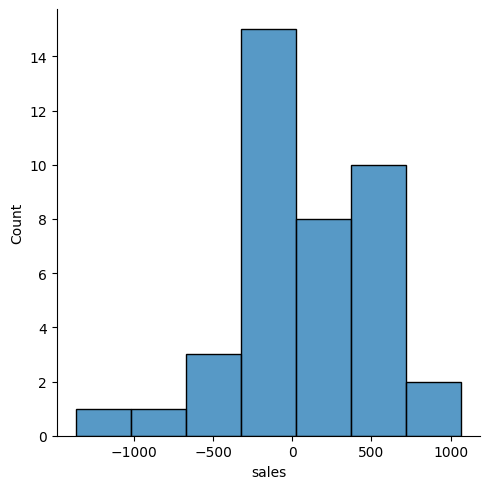

In [92]:
sns.displot(y3_test-pred3l)

De aquí interpretamos que los errores siguen una distribución normal, aunque el modelo parece subestimar las ventas (real - estimado es positivo)

<Axes: ylabel='sales'>

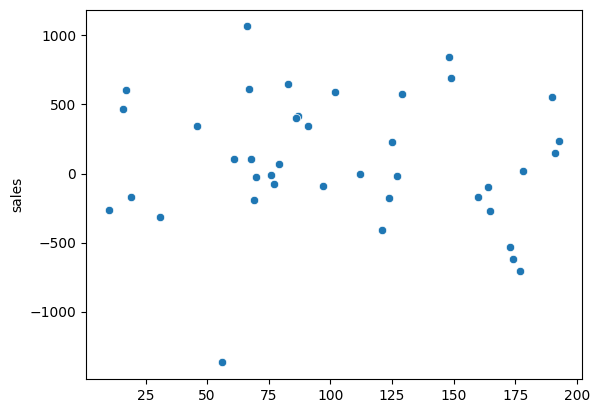

In [94]:
sns.scatterplot(y3_test-pred3l)

In [19]:
# Utiliza todas las celdas que necesites...